# Calibrating Marrmot M14 using the ewatercycle system

Make sure your ewatercycle conda environment is [activated](https://github.com/eWaterCycle/ewatercycle#install).

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import time
import hashlib
from pathlib import Path
import hydrostats.metrics as hm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
from cartopy.io import shapereader
from cftime import date2num
from ruamel.yaml import YAML

In [3]:
import cma
from cma.fitness_transformations import EvalParallel2

In [4]:
import ewatercycle.models
from ewatercycle.config import CFG
from ewatercycle.util import get_time
from ewatercycle.forcing import load_foreign
from ewatercycle.observation.grdc import get_grdc_data

yaml = YAML()
yaml.default_flow_style = False

In [5]:
# General settings
# Note that we use capitals for 'global' variables.
# project directories for model input i.e. shape files and forcing
SHAPE_DIR = Path("/projects/0/wtrcycle/comparison/recipes_auxiliary_datasets/Lorentz_Basin_Shapefiles")

# periods for calibration
CALIBRATION = {
    'spinup_start': '1990-01-01T00:00:00Z',
    'start': '1991-01-01T00:00:00Z',
    'end': '2001-12-31T00:00:00Z',
}

## 1. Loading forcing data

In [6]:
FORCING = load_foreign('marrmot',
                        directory='/projects/0/wtrcycle/comparison/forcing/marrmot-m01',
                        start_time=CALIBRATION['spinup_start'],
                        end_time=CALIBRATION['end'],
                        forcing_info={
                            'forcing_file': 'marrmot-m01_ERA5_Savannah_1990_2001.mat'
                        })

## 2. Loading eWaterCycle configuration file

Config settings on Cartesius:
``` yaml
grdc_location: '/projects/0/wtrcycle/comparison/GRDC/GRDC_GCOSGTN-H_27_03_2019'
container_engine: 'singularity'
singularity_dir: '/scratch/shared/ewatercycle/case3_marrmot14'
output_dir: '/scratch/shared/ewatercycle/case3_marrmot14'
```

In [7]:
CFG.load_from_file('./ewatercycle.yaml')

## 3. Functions for calibration

These functions can be used to perform the calibration of the model. The function `objective_function()` can be used as first argument to the optimization methods. As optimization metric we use that Nash–Sutcliffe model efficiency coefficient (NSE), comparing the model output with GRDC data. NSE values range between `-inf < NSE < 1` with close to 1 indicating a good match, while the optimization expects the closer to zero the better. Therefore we use the value `1 - nse_value` as objective function.

### Calibration

We use the [CMA Evolution Strategy (CMA-ES) algorithm](https://github.com/CMA-ES/pycma) package.
The CMA-ES is initialized with:

 - initial value (mean) x0 = 7 * [5], here 7 is the number of variables, 5 is the mean value in range [0, 10].
 - initial step size (standard deviation) sigma0=2.0.
 - options

The values for `bounds` and  `sigma0` are chosen based on the guides in
[practical hints](http://cma.gforge.inria.fr/cmaes_sourcecode_page.html#practical),
see sections **Encoding of Variables** and **Initial Values**.
The `bounds` are used to make the `transform` function, see below.

For more information about `parallel processing` see the
[API documention](http://cma.gforge.inria.fr/apidocs-pycma/cma.fitness_transformations.EvalParallel2.html),
and about `ask-and-tell interface` see an example at https://pypi.org/project/cma/.

### Practical hints
The `run_model()` function uses two CPU cores (model-octave, and bmi-server)
and takes about 4 min to run the model for a period e.g. CALIBRATION.
There are 24 cores available in a `normal` partition on Cartesius.
If you want to keep the running time to 4 min for e.g. CALIBRATION, you can
have 12 runs simultaneously. Therefore, the `popsize:12` in the cma-es option.
If you want to get the results of the whole notebook after a
reasenable amount of time, you can change `maxiter` in the cma-es option.

In [8]:
def run_model(parameters):
    """Setup and run model."""
    model = ewatercycle.models.MarrmotM14(version='2020.11', forcing=FORCING)
    
    # Generate a random tag for work_dir name
    # Each work_dir is used by one worker in multiprocessing
    tag = hashlib.md5(str(parameters).encode('utf-8')).hexdigest()
    work_dir = CFG['output_dir'] / f"marrmot-m14_{tag}"
        
    cfg_file, cfg_dir = model.setup(
        cfg_dir=work_dir,
        maximum_soil_moisture_storage=parameters[0],
        threshold_flow_generation_evap_change=parameters[1],
        leakage_saturated_zone_flow_coefficient=parameters[2],
        zero_deficit_base_flow_speed=parameters[3],
        baseflow_coefficient=parameters[4],
        gamma_distribution_chi_parameter=parameters[5],
        gamma_distribution_phi_parameter=parameters[6],
        initial_upper_zone_storage=0.9*parameters[0],
        initial_saturated_zone_storage=0.9*parameters[0],
        start_time=CALIBRATION['spinup_start'],
        end_time=CALIBRATION['end'],
    )
    
    # Initialize the model inside the docker container through GRPC4bmi
    model.initialize(str(cfg_file))
    
    # Convert start to date number to be used in if statement
    start_time = date2num(
        get_time(CALIBRATION['start']),
        model.time_units
    )
    simulated_discharge = []
    end_time = model.end_time
    # Perform all timesteps of the model, update output fields
    while (model.time < end_time):
        model.update()
        # Store model time and variable output after the spin up period
        if model.time >= start_time:
            simulated_discharge.append(model.get_value('flux_out_Q')[0])
    model.finalize()
    return np.array(simulated_discharge)


def get_catchment_area(catchment):
    """Get the catchment area in m2."""
    shapefile = SHAPE_DIR / catchment / f'{catchment}.shp'
    shape = shapereader.Reader(shapefile)
    attr = next(shape.records())
    return attr.attributes['SUB_AREA'] * 1e6


def get_observations(station_id):
    """Get GRDC observation data."""
    observations, metadata = get_grdc_data(station_id, CALIBRATION["start"], CALIBRATION["end"])
    return observations['streamflow']


def objective_function(parameters, observation, area):
    """Calculate objective function.

    Runs the model, converts the output to GRDC streamflow units
    and calculates NSE from simulation data with observation data.
    This is the function that is going to be optimized by scipy.brute.
    """
    simulation = run_model(parameters)
    # flux_out_Q unit conversion factor from mm/day to m3/s
    conversion = 1 / (1000 * 86400)
    # convert simulated streamflow to same units as observation
    simulation = simulation * area * conversion
    nse_value = hm.nse(simulation, observation)
    return 1 - nse_value


def transform(scaled_parameters):
    """Transforms the scaled_parameter to parameter.

    if x = scaled_parameter and y = parameter,
    then x is in the range [0, 10] and y is in the range [a, b].
    To map the values [0, 10] into [a, b],
    we use the transformations a + (b-a) * x/10.
    For more information on this transformation,
    please see
    http://cma.gforge.inria.fr/cmaes_sourcecode_page.html#practical
    """
    parameters = []
    for scaled_parameter, bound in zip(scaled_parameters, PARAMETERS_BOUNDS):
        scale = (bound[1] - bound[0]) / 10.0
        parameter = bound[0] + (scale * scaled_parameter)
        parameters.append(parameter)
    return parameters


def wrapped_objective_function(scaled_parameters, *args):
    """A wrapper around the objective function.

    The wrapper transforms the scaled_parameters before
    the actual function call.
    """
    parameters = transform(scaled_parameters)
    return objective_function(parameters, *args)


def run_calibration(parameter_bounds, observation, area):
    """Return the optimum parameters found by CMA-ES method."""
    # Set some options for optimization needed when multiprocessing
    options = cma.CMAOptions()
    options.set({
        'bounds': [0, 10],  # for scaled parameters
        'seed': 1234,  # set a seed to reproduce results
        'verbose': -9,  # verbosity of initial/final message: maximally quiet
        'popsize': 12,  # equal to number of available cores/2
        # termination conditions: if one item is True, cma-es will stop
        'maxiter': 50,  # with this, the notebook takes ~4 hours (maximum)
        'tolfun': 1e-17,  # very small value due to model creeping behavior
        'tolx': 1e-5,
        'verb_filenameprefix': str(CFG['output_dir']),  # cma-es output path
    })

    no_of_variables = len(parameter_bounds)
    # initial mean value and standard deviation
    x0 = 5.0
    sigma0 = 2.0

    # Initialize the CMA-ES
    cma_es = cma.CMAEvolutionStrategy(no_of_variables * [x0], sigma0, options)

    # Store the results of each iteration
    all_scores = []
    all_parameters = []
    
    # Use parallel processing
    with EvalParallel2(number_of_processes=options['popsize']) as evaluations:
        # Use ask-and-tell interface
        while not cma_es.stop():
            solutions = cma_es.ask()
            cma_es.tell(
                solutions,
                evaluations(
                    solutions,
                    fitness_function=wrapped_objective_function,
                    args=(observation, area)
                ),
            )
            # Use transform to return parameters and not scaled ones
            all_parameters.append(transform(cma_es.best.last.x))
            all_scores.append(cma_es.best.last.f)
    print(f"---- CMA-ES stopped due to: {cma_es.stop()} ----")

    # Make full output
    full_output = (transform(cma_es.result.xbest),
                   cma_es.result.fbest,
                   all_parameters,
                   all_scores)
    return full_output

## 4. Running the calibration

In [9]:
# M14 parameter bounds
PARAMETERS_BOUNDS = [[1.0, 2000.0],
                     [0.05, 0.95],
                     [0.0, 1.0],
                     [0.1, 200.0],
                     [0.0, 1.0],
                     [1.0, 7.5],
                     [0.1, 5.0]]

observation = get_observations('4148650')
area = get_catchment_area('Savannah')  
exec_start_time = time.time()
full_output = run_calibration(PARAMETERS_BOUNDS, observation, area)
print(f"Calibration is completed in {time.time() - exec_start_time} seconds")

GRDC station 4148650 is selected. The river name is: SAVANNAH RIVER.The coordinates are: (32.5282, -81.2687).The catchment area in km2 is: 25511.5. There are 1 missing values during 1991-01-01T00:00:00Z_2001-12-31T00:00:00Z at this station. See the metadata for more information.
Running /scratch/shared/ewatercycle/case3_marrmot14/ewatercycle-marrmot-grpc4bmi_2020.11.sif singularity container on port 39688
Running /scratch/shared/ewatercycle/case3_marrmot14/ewatercycle-marrmot-grpc4bmi_2020.11.sif singularity container on port 34399
Running /scratch/shared/ewatercycle/case3_marrmot14/ewatercycle-marrmot-grpc4bmi_2020.11.sif singularity container on port 40662
Running /scratch/shared/ewatercycle/case3_marrmot14/ewatercycle-marrmot-grpc4bmi_2020.11.sif singularity container on port 38487
Running /scratch/shared/ewatercycle/case3_marrmot14/ewatercycle-marrmot-grpc4bmi_2020.11.sif singularity container on port 45544
Running /scratch/shared/ewatercycle/case3_marrmot14/ewatercycle-marrmot-grp

In [10]:
## Save model parameters obtained by optimization as a yml file.
best_par, best_score, pars, scores = full_output

# Use float () to convert to plain Python types
other_values = [
    ([float(z) for z in x], float(1 - y)) for x, y in zip(pars, scores)
]
results_doc = {
    'title': 'MARRMoT m14 model optimized parameter based on NSE',
    'best_parameter_value': [float(x) for x in best_par],
    'best_NSE_value': float(1 - best_score),
    'other_values': other_values,
}

# it is saved in the output directory
filename = f"{CFG['output_dir']}/marrmot-m14_ERA5_Savannah_calibration_{CALIBRATION['start']}_{CALIBRATION['end']}.yml" 
with open(filename, 'w+') as f:
    yaml.dump(results_doc, f)
print(f'Calibration results saved in {filename}')

Calibration results saved in /scratch/shared/ewatercycle/case3_marrmot14/marrmot-m14_ERA5_Savannah_calibration_1991-01-01T00:00:00Z_2001-12-31T00:00:00Z.yml


## 5. Plotting the optimization results

In [11]:
def plot_parameters(results):
    """Make a plot showing optimization results."""
    
    # Create a figure with left and right axis
    fig, ax = plt.subplots(figsize=(10, 4), dpi=120)

    # Plot NSE vs. iteration index obtained by calibration
    label_text = {}
    data = results["other_values"]
    all_parameters, all_scores = list(zip(*data))
    ax.plot(range(1, len(all_scores) + 1), all_scores)

    # Add parameters of each iteration as a text
    iterations = []
    for iteration, parameters in enumerate(all_parameters):
        parameters_as_str = ', '.join(f'{par:.2f}' for par in parameters)
        iterations.append(f"{iteration + 1}: {parameters_as_str}")
    label_text = '\n'.join(iterations)

    ax.set_xlabel("Iteration", fontsize=12)
    ax.set_ylabel("NSE", fontsize=12)
    ax.set_title("Model: MARRMoT m14, Catchment: Savannah", loc="left")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # x-axis is integer

    # Combine and plot legend
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='lower right', prop={"size": 8})

    # Add statistics
    best_parameters = ', '.join(
        f"{par:.2f}" for par in results['best_parameter_value']
    )
    statistics = "\n".join(
        [
            f"best NSE value: {results['best_NSE_value']:.2f}",
            f"best parameters: {best_parameters}",
            "-------------------------------",
            "Iterations, parameters",
            f"{label_text}",
        ]
    )

    box = {"edgecolor": "blue", "facecolor": "white"}
    ax.text(
        1.06,
        0.98,
        statistics,
        transform=ax.transAxes,
        va="top",
        bbox=box,
        fontsize=6,
    )

    # Show grid
    plt.grid(True)

    # Fix legend falling off figure
    fig.tight_layout()
    plt.show()

    return fig

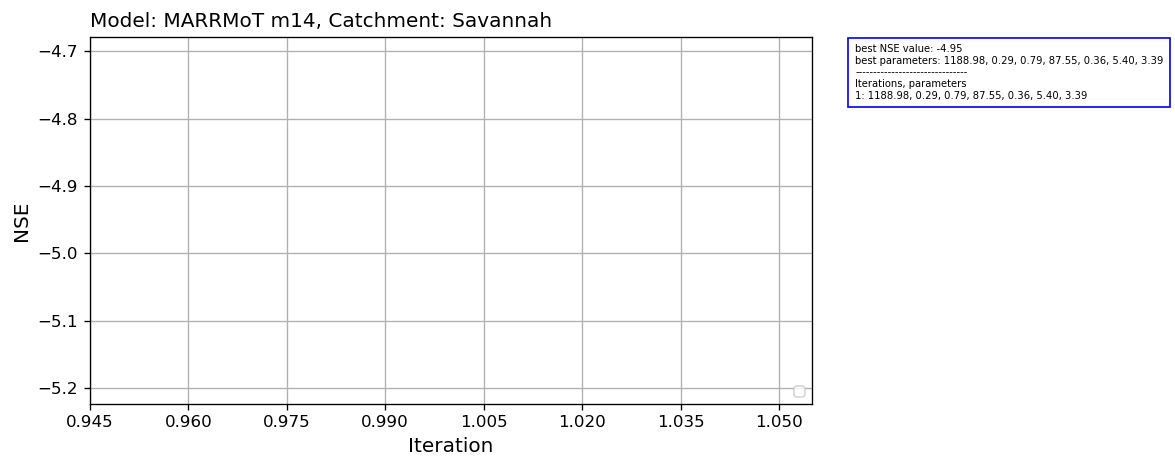

In [12]:
# Plot
# it is located in the output directory
filename = f"{CFG['output_dir']}/marrmot-m14_ERA5_Savannah_calibration_{CALIBRATION['start']}_{CALIBRATION['end']}.yml" 
with open(filename) as f:
    calibration_results = yaml.load(f)
fig = plot_parameters(calibration_results)
fig.savefig(f"{filename}.png", bbox_inches="tight", dpi=300)